# Setup

In [2]:
# RNN reference: https://www.kaggle.com/aadhavvignesh/pytorch-garbage-classification-95-accuracy
# PyTorch data preprocessing reference: https://www.kaggle.com/altanai/garbage-segrigation-on-pytorch-95-accuracy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()  

#Set the run time to be GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


In [3]:
from google.colab import drive
drive.mount("/content/drive")
data_dir = "/content/drive/My Drive/CIS519_Project/garbage_data/Garbage_classification/Garbage_classification"

classes = os.listdir(data_dir)
print(classes)

Mounted at /content/drive
['trash', 'glass', 'cardboard', 'paper', 'metal', 'plastic']


In [23]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

# Transform the image to be size 28 * 28
transformations = transforms.Compose([ transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = ImageFolder(data_dir, transform = transformations)

dataset

Dataset ImageFolder
    Number of datapoints: 2527
    Root location: /content/drive/My Drive/CIS519_Project/garbage_data/Garbage_classification/Garbage_classification
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [24]:
#A helper function to see image and its corresponding label
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: cardboard (Class No: 0)


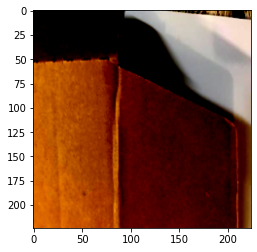

In [25]:
img, label = dataset[17]
show_sample(img, label)

# Loading Data

In [26]:
# Set Random Seed
random_seed = 42
torch.manual_seed(random_seed)

In [27]:
from torch.utils import data
train_ds, val_ds,test_ds = data.random_split(dataset, [1593, 176,758])
len(train_ds), len(val_ds), len(test_ds)
# train_ds, val_ds, test_ds = data.random_split(dataset, [1593, 176, 758])
# len(train_ds), len(val_ds), len(test_ds)

(1593, 176, 758)

In [28]:
train_ds

In [29]:
val_ds

In [30]:
# test_ds

In [31]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

In [32]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 2, pin_memory = True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [33]:
#Helper function to visualize batches
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


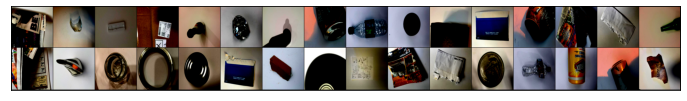

In [34]:
show_batch(train_dl)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


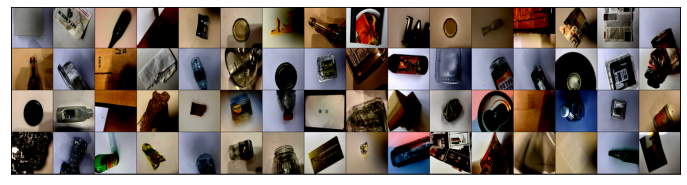

In [ ]:
show_batch(val_dl)

# Googlenet


Reference1: https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce

Reference2: https://debuggercafe.com/transfer-learning-with-pytorch/

## Loading Model

In [15]:
from torchvision import models
model = models.googlenet(pretrained=True)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


In [ ]:
print(model)

## Freeze weights & Update classifier

In [35]:
# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

In [37]:
import torch.nn as nn
# Add on classifier
# add layers
# num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
                      nn.Linear(num_ftrs, 1024), 
                      nn.ReLU(), 
                      nn.Dropout(0.2),
                      nn.Linear(1024, 256),
                      nn.ReLU(),
                      nn.Dropout(0.2), 
                      # nn.AdaptiveAvgPool2d((256)),
                      nn.Linear(256, len(classes)),
                      nn.LogSoftmax(dim=1))

In [38]:
model.fc

Sequential(
  (0): Linear(in_features=1024, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=1024, out_features=256, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=256, out_features=6, bias=True)
  (7): LogSoftmax(dim=1)
)

In [39]:
model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [40]:
!pip install pytorch_model_summary
from torchsummary import summary

# summary(model,input_size = (3,224,224))

In [52]:
summary(model,input_size = (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
       BasicConv2d-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
       BasicConv2d-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 192, 56, 56]         110,592
       BatchNorm2d-9          [-1, 192, 56, 56]             384
      BasicConv2d-10          [-1, 192, 56, 56]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          12,288
      BatchNorm2d-13           [-1, 64, 28, 28]             128
      BasicConv2d-14           [-1, 64,

## Training

In [48]:
import torch
torch.cuda.empty_cache()

In [49]:
model = model.cuda()

In [50]:
from torch import optim
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [51]:
def get_validaion_loss(model):
  loss = 0
  total = 0 
  with torch.no_grad():
    for data in val_dl:
        images, labels = data
        total += labels.size(0)
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        loss += criterion(outputs, labels).item()
  return loss / total
        # _, predicted = torch.max(outputs.data, 1)
        # total += labels.size(0)
        # correct += (predicted == labels.cuda()).sum().item()

In [ ]:
training_loss = []
validaion_loss = []
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dl, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # print(loss.item())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 0:    # print every epoch
          print('Epoch: %d loss: %.3f' % (epoch + 1, running_loss/50))
          # print("val:", validaion_loss)
          training_loss.append(running_loss/50)
          validaion_loss.append(get_validaion_loss(model))
          print("val:", get_validaion_loss(model))
          running_loss = 0.0

print('Finished Training')
torch.save(model, 'baseline_model.pth')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 1 loss: 0.036
val: 0.02803260317706449
Epoch: 2 loss: 0.025
val: 0.018495125867569982
Epoch: 3 loss: 0.021
val: 0.013523769455241953
Epoch: 4 loss: 0.008
val: 0.011341710417377871
Epoch: 5 loss: 0.009
val: 0.011200420351048864
Epoch: 6 loss: 0.015
val: 0.010519626053803993
Epoch: 7 loss: 0.006
val: 0.009675962894325338
Epoch: 8 loss: 0.012
val: 0.01009723486685906
Epoch: 9 loss: 0.005
val: 0.010246867286061322
Epoch: 10 loss: 0.010
val: 0.009308053926431137
Epoch: 11 loss: 0.007
val: 0.009483988011929923
Epoch: 12 loss: 0.008
val: 0.010221878485454992
Epoch: 13 loss: 0.008
val: 0.009991799834198309
Epoch: 14 loss: 0.007
val: 0.009473664123700569
Epoch: 15 loss: 0.003
val: 0.009968965767027224
Epoch: 16 loss: 0.009
val: 0.009504147783336598
Epoch: 17 loss: 0.004
val: 0.00974840895777341
Epoch: 18 loss: 0.006
val: 0.010198249870500421
Epoch: 19 loss: 0.007
val: 0.00990953511803768
Epoch: 20 loss: 0.009
val: 0.009412917354377486
Finished Training


In [ ]:
print(training_loss, validaion_loss)

[0.03592265129089355, 0.024581451416015625, 0.02148054838180542, 0.008390957117080688, 0.009330331087112427, 0.014727627038955688, 0.005537924170494079, 0.011988569498062134, 0.00450416088104248, 0.010436961650848389, 0.007309790849685669, 0.007572357058525086, 0.007834354639053345, 0.006616207361221313, 0.0029325976967811583, 0.009018309116363525, 0.00414539635181427, 0.005874058604240418, 0.006641830205917358, 0.009105707406997681] [0.028051173661454588, 0.018678385644704424, 0.013577459902528522, 0.011529309336072118, 0.010551149571988517, 0.010362761147017141, 0.01007273528381895, 0.009704043638016989, 0.010268513408411749, 0.009674230020102393, 0.009625609062723736, 0.009524520095716962, 0.009996910996304334, 0.009416366797698387, 0.009602950171944416, 0.00955099764038715, 0.009380469772749336, 0.010678542981311136, 0.010653165027467291, 0.009441518841004219]


Text(0.5, 1.0, 'GoogleNet')

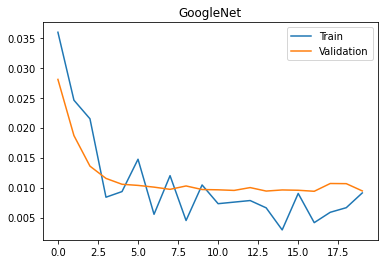

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(training_loss)
plt.plot(validaion_loss)
plt.legend(['Train', 'Validation'])
plt.title('GoogleNet')

## Test

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


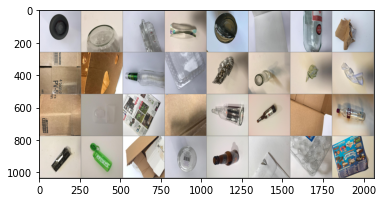

cardboard glass metal paper cardboard trash glass trash trash trash glass metal cardboard glass paper paper trash metal paper trash glass glass trash glass metal metal trash metal glass paper metal paper


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_dl)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(len(labels))))

In [ ]:
# Test - output
outputs = model(images.cuda())
_, predicted = torch.max(outputs, 1)
print(predicted)
# print(classes[predicted[0]])
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(len(predicted))))

tensor([2, 1, 4, 3, 2, 3, 1, 3, 0, 0, 1, 4, 2, 1, 3, 3, 0, 4, 3, 5, 1, 1, 0, 1,
        4, 4, 0, 2, 1, 3, 4, 3], device='cuda:0')
Predicted:  cardboard glass metal paper cardboard paper glass paper trash trash glass metal cardboard glass paper paper trash metal paper plastic glass glass trash glass metal metal trash cardboard glass paper metal paper


In [ ]:
nb_classes = 6 #Data Augmnetation F scores & Accuracies

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for inputs, classes in train_dl:
        inputs = inputs.cuda()
        classes = classes.cuda()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

# To get the per-class accuracy: precision
precision = confusion_matrix.diag()/confusion_matrix.sum(1)
print(confusion_matrix.diag()/confusion_matrix.sum(1))

recall = confusion_matrix.diag()/confusion_matrix.sum(1)
print(confusion_matrix.diag()/confusion_matrix.sum(0))

f1 = 2*precision*recall/(precision+recall)
print(f1)
print("Training F score", f1.numpy().mean())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor([[224.,   1.,   4.,  16.,   8.,   5.],
        [  0., 302.,   8.,   0.,  11.,   1.],
        [  0.,  18., 223.,   1.,   5.,   3.],
        [  1.,   0.,   3., 365.,   6.,   7.],
        [  0.,  21.,   6.,   2., 273.,   4.],
        [  0.,   1.,   1.,   0.,   1.,  72.]])
tensor([0.8682, 0.9379, 0.8920, 0.9555, 0.8922, 0.9600])
tensor([0.9956, 0.8805, 0.9102, 0.9505, 0.8980, 0.7826])
tensor([0.8682, 0.9379, 0.8920, 0.9555, 0.8922, 0.9600])
Training F score 0.91762656


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in val_dl:
        images, labels = data
        outputs = model(images.cuda())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum().item()

print(100 * correct / total)
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

81.37044967880085
Accuracy of the network on the 10000 test images: 81 %


In [ ]:
nb_classes = 6

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for inputs, classes in val_dl:
        inputs = inputs.cuda()
        classes = classes.cuda()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

# To get the per-class accuracy: precision
precision = confusion_matrix.diag()/confusion_matrix.sum(1)
print(confusion_matrix.diag()/confusion_matrix.sum(1))

recall = confusion_matrix.diag()/confusion_matrix.sum(1)
print(confusion_matrix.diag()/confusion_matrix.sum(0))

f1 = 2*precision*recall/(precision+recall)
print(f1)
print("Validation F score", f1.numpy().mean())

tensor([[114.,   0.,   4.,  22.,   1.,   4.],
        [  0., 155.,   4.,   0.,  17.,   3.],
        [  0.,  34., 116.,   2.,   6.,   2.],
        [  1.,   2.,   5., 190.,   3.,  11.],
        [  1.,  16.,   7.,   4., 142.,   6.],
        [  4.,   0.,   3.,   8.,   4.,  43.]])
tensor([0.7862, 0.8659, 0.7250, 0.8962, 0.8068, 0.6935])
tensor([0.9500, 0.7488, 0.8345, 0.8407, 0.8208, 0.6232])
tensor([0.7862, 0.8659, 0.7250, 0.8962, 0.8068, 0.6935])
Validation F score 0.7956202


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in train_dl:
        images, labels = data
        outputs = model(images.cuda())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum().item()

print(100 * correct / total)
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


90.77212806026365
Accuracy of the network on the 10000 test images: 90 %


In [ ]:
nb_classes = 6
test_dl = DataLoader(test_ds,batch_size*2, num_workers = 2, pin_memory = True)
confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for inputs, classes in test_dl:
        inputs = inputs.cuda()
        classes = classes.cuda()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

# To get the per-class accuracy: precision
precision = confusion_matrix.diag()/confusion_matrix.sum(1)
print(confusion_matrix.diag()/confusion_matrix.sum(1))

recall = confusion_matrix.diag()/confusion_matrix.sum(1)
print(confusion_matrix.diag()/confusion_matrix.sum(0))

f1 = 2*precision*recall/(precision+recall)
print(f1)
print("Test F score", f1.numpy().mean())

tensor([[101.,   1.,   2.,  12.,   2.,   2.],
        [  0., 141.,   3.,   0.,   6.,   1.],
        [  0.,  14., 106.,   1.,   1.,   0.],
        [  0.,   3.,   1., 159.,   4.,   4.],
        [  1.,  10.,   6.,   2., 135.,   0.],
        [  1.,   0.,   1.,   1.,   1.,  36.]])
tensor([0.8417, 0.9338, 0.8689, 0.9298, 0.8766, 0.9000])
tensor([0.9806, 0.8343, 0.8908, 0.9086, 0.9060, 0.8372])
tensor([0.8417, 0.9338, 0.8689, 0.9298, 0.8766, 0.9000])
Test F score 0.89179033


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_dl:
        images, labels = data
        outputs = model(images.cuda())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum().item()

print(100 * correct / total)
print('Accuracy of the network on the 758 test images: %d %%' % (
    100 * correct / total))

88.91820580474933
Accuracy of the network on the 758 test images: 88 %
